# Cell Concentrations

Data visualization of per cell concentration and voltage measurements of SISPS-EXP-SOC experiment.

[Lawrence Stanton](mailto:stnlaw003@myuct.ac.za)

## Notes and Context on Data

Following all ex-situ electronic investigation, the batteries were cut apart. Cell voltages were measured as soon as the electric nodes were available to probe. Cells were then pulled out of the plastic body. Electrode plates were cut from the parallel connection bar, deaminated, and AGM mats were extracted, squeezed and bottled. The acid samples contained significant amounts lead, visible as solids in suspension.

Batch A was done first while Batch B was performing charge cycles. Unfortunately, during this time the samples were exposed to sunlight. After a further long period of time the samples were analyzed, but by which time the lids of the sample bottles of Batch A had cracked from embrittlement. Although most samples were still effectively contained, not all were, hence a bias in the number of rejects in [Preprocessing 2](#preprocessing-2).

Concentration was measured via a density measurement using an [Anton Paar DMA 35](https://www.anton-paar.com/corp-en/products/details/portable-density-meter-dmatm-35-basic) handled density meter. The meter includes an automatic temperature compensation and sulfuric acid weight percentage calculation using built-in lookup tables, as was recorded as the measurement. Fundamentally the measurement is taken using 

## Environment

Create a python environment using the provided `environment.yml` file.

```bash
conda env create -f environment.yml
```

```{note}
Last tested using Python 3.11
```


## Defaults

In [37]:
from typing import Tuple

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial

import darkdetect

plt.rcParams.update(plt.rcParamsDefault)

if darkdetect.isDark():
    plt.style.use("dark_background")

plt.rcParams.update(
    {
        "figure.dpi": 300,
        "figure.figsize": (8, 5),
    }
)

VOLTAGE_FORMATTER = plt.FuncFormatter(lambda x, _: f"{x:.2f}\u200cV")

%config InlineBackend.figure_format = 'svg'

## Helpers

In [38]:
def getCorrelation(data: pd.DataFrame) -> Tuple[Polynomial, float]:
    p = Polynomial.fit(data["Density (wt%)"], data["Voltage"], 1)
    r2 = np.corrcoef(data["Density (wt%)"], data["Voltage"])[0, 1] ** 2
    return p, r2

## Data Import

In [39]:
DATA_FILE = "../Data/UCT002 Cell Densities and Voltages.xlsx"

RAW_DATA = pd.read_excel(
    DATA_FILE,
    sheet_name="Sheet1",
    usecols="A:E",
    header=3,
    skipfooter=4,
)

print(RAW_DATA.head(8))
print(RAW_DATA.tail(8))

  Battery Cell  Voltage  Density (wt%)  Temperature (°C)
0     A01    I    2.189          0.423              23.6
1     NaN   II    2.184          0.428              23.6
2     NaN  III    2.176          0.426              23.3
3     NaN   IV    2.177          0.410              24.1
4     NaN    V    2.186          0.423              23.4
5     NaN   VI    2.179          0.431              23.5
6     A02    I    2.167          0.415              23.1
7     NaN   II    2.168          0.410              23.6
    Battery Cell  Voltage  Density (wt%)  Temperature (°C)
113     NaN   VI    1.949            NaN               NaN
114     B10    I    1.941            NaN               NaN
115     NaN   II    1.937          0.133              22.8
116     NaN  III    1.946          0.146              23.4
117     NaN   IV    1.943          0.158              22.6
118     NaN    V    1.945          0.158              22.4
119     NaN   VI    1.952          0.157              22.7
120     NaN  Na

## Preprocessing 1

In [40]:
# Fill in the missing Battery values
RAW_DATA["Battery"] = RAW_DATA["Battery"].ffill()

# Label Battery Batch and Number
RAW_DATA["Batch"] = RAW_DATA["Battery"].str[0]
RAW_DATA["Number"] = RAW_DATA["Battery"].str[1:].astype(int)

# Drop rows with NaN values
RAW_DATA = RAW_DATA.dropna()

print(RAW_DATA.head(8))
print(RAW_DATA.tail(8))

  Battery Cell  Voltage  Density (wt%)  Temperature (°C) Batch  Number
0     A01    I    2.189          0.423              23.6     A       1
1     A01   II    2.184          0.428              23.6     A       1
2     A01  III    2.176          0.426              23.3     A       1
3     A01   IV    2.177          0.410              24.1     A       1
4     A01    V    2.186          0.423              23.4     A       1
5     A01   VI    2.179          0.431              23.5     A       1
6     A02    I    2.167          0.415              23.1     A       2
7     A02   II    2.168          0.410              23.6     A       2
    Battery Cell  Voltage  Density (wt%)  Temperature (°C) Batch  Number
110     B09  III    1.949          0.149              22.5     B       9
111     B09   IV    1.958          0.169              22.8     B       9
112     B09    V    1.954          0.162              23.0     B       9
115     B10   II    1.937          0.133              22.8     B     

## Raw Data Visualization


### Scatter Plots

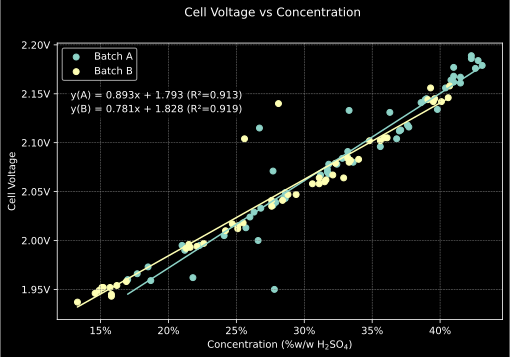

In [41]:
def plotDensityVoltageScatter(data: pd.DataFrame) -> plt.Figure:
    """
    Scatter plot of Voltage vs Density, grouped by Battery Batch.
    """
    fig, ax = plt.subplots()
    for batch, group in data.groupby("Batch"):
        p, r2 = getCorrelation(group)
        monomial = p.convert()
        a, b = monomial.coef[1], monomial.coef[0]

        ax.scatter(
            group["Density (wt%)"],
            group["Voltage"],
            marker="o",
            label=f"Batch {batch}",
        )
        ax.plot(
            group["Density (wt%)"],
            p(group["Density (wt%)"]),
        )
        ax.text(
            0.03,
            0.80 if batch == "A" else 0.75,
            f"y({batch}) = {a:.3f}x + {b:.3f} (R²={r2:.3f})",
            transform=ax.transAxes,
            bbox=dict(
                facecolor="black" if darkdetect.isDark() else "white",
                alpha=0.7,
                edgecolor="none",
            ),
        )

    ax.set_xlabel(r"Concentration (%w/w H$_2$SO$_4$)")
    ax.set_ylabel("Cell Voltage")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="grey")
    ax.xaxis.set_major_formatter(PercentFormatter(1, 0))
    ax.yaxis.set_major_formatter(VOLTAGE_FORMATTER)
    ax.legend()
    fig.suptitle("Cell Voltage vs Concentration")

    return fig


plotDensityVoltageScatter(RAW_DATA)

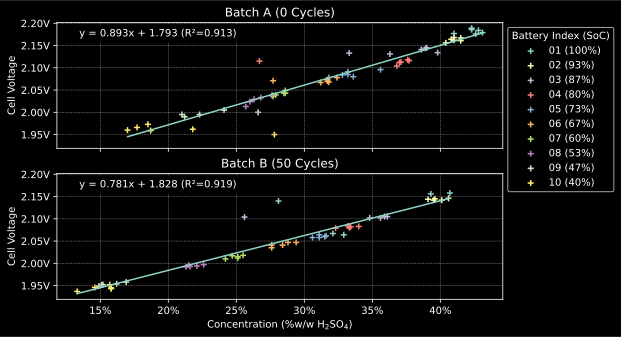

In [42]:
from Lib.eisAnalysis import getSocByNumber


def plotDensityVoltageScatterByBatch(
    data: pd.DataFrame,
    lightModeOverride: bool = False,
) -> plt.Figure:
    """
    Scatter plot of Voltage vs Density, grouped by Battery Batch, separate subplots.
    """
    fig, ax = plt.subplots(
        2,
        1,
        sharex=True,
        sharey=True,
    )

    for batch, group in data.groupby("Batch"):
        axis = ax[0] if batch == "A" else ax[1]

        p, r2 = getCorrelation(group)
        monomial = p.convert()
        a, b = monomial.coef[1], monomial.coef[0]

        axis.plot(
            group["Density (wt%)"],
            p(group["Density (wt%)"]),
        )

        for number, subgroup in group.groupby("Number"):
            axis.scatter(
                subgroup["Density (wt%)"],
                subgroup["Voltage"],
                marker="+",
                label=f"{number:02d} ({getSocByNumber(number)})",
            )

        # place text on the graph of polyfit
        axis.text(
            0.05,
            0.95,
            f"y = {a:.3f}x + {b:.3f} (R²={r2:.3f})",
            transform=axis.transAxes,
            verticalalignment="top",
            bbox=dict(
                facecolor=(
                    "black"
                    if not lightModeOverride and darkdetect.isDark()
                    else "white"
                ),
                alpha=1,
                edgecolor="none",
            ),
        )

        axis.set_title(f"Batch {batch} ({0 if batch == 'A' else 50} Cycles)")

        axis.grid(
            True,
            which="both",
            linestyle="--",
            linewidth=0.5,
            color="grey",
        )
        axis.xaxis.set_major_formatter(PercentFormatter(1, 0))
        axis.yaxis.set_major_formatter(VOLTAGE_FORMATTER)

        if batch == "B":
            axis.set_xlabel(r"Concentration (%w/w H$_2$SO$_4$)")
        axis.set_ylabel("Cell Voltage")

        if batch == "A":
            axis.legend(
                title="Battery Index (SoC)",
                bbox_to_anchor=(1, 1),
            )
    # fig.suptitle("Cell Voltage to Density")

    return fig


plotDensityVoltageScatterByBatch(RAW_DATA)

## Preprocessing 2

It is well established by the Nernst equation that the voltage is a function of the concentration. Therefore, should a point deviate significantly in density as compared to its voltage, discard it as an outlier.

Points in this static dataset are manually selected and removed.

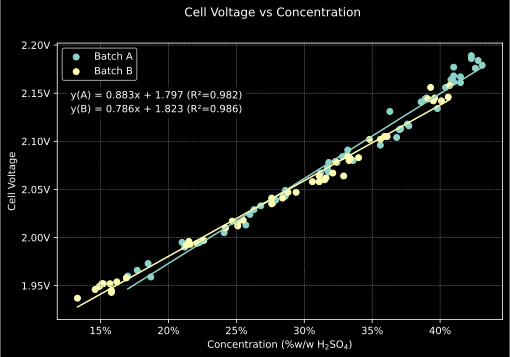

In [43]:
# Delete points inconsistent with linear density-voltage trend

KNOWN_BAD_CELLS = [
    ["A03", "III"],
    ["A04", "I"],
    ["A06", "VI"],
    ["A09", "I"],
    ["A10", "I"],
    ["A10", "IV"],
    ["B01", "IV"],
    ["B03", "II"],
]

DATA = RAW_DATA.copy()
for battery, cell in KNOWN_BAD_CELLS:
    DATA = DATA[~((DATA["Battery"] == battery) & (DATA["Cell"] == cell))]

plotDensityVoltageScatter(DATA)

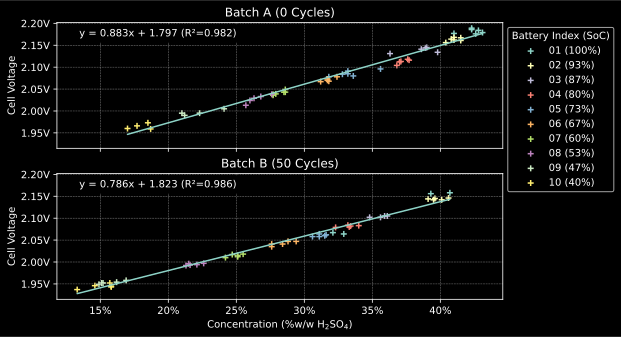

In [44]:
plotDensityVoltageScatterByBatch(DATA)

## Analysis

### Mean Concentrations

In [45]:
# Calculate the mean acid density for each battery and uncertainty

DENSITY_MEAN = DATA.groupby("Battery")["Density (wt%)"].mean()
DENSITY_STD = DATA.groupby("Battery")["Density (wt%)"].std()

# Restore the Batch and Number columns
DENSITY_MEAN = DENSITY_MEAN.reset_index()
DENSITY_MEAN["Number"] = DENSITY_MEAN["Battery"].str[1:]
DENSITY_MEAN["Batch"] = DENSITY_MEAN["Battery"].str[0]

DENSITY_STD = DENSITY_STD.reset_index()
DENSITY_STD["Number"] = DENSITY_STD["Battery"].str[1:]
DENSITY_STD["Batch"] = DENSITY_STD["Battery"].str[0]

print(DENSITY_MEAN)

   Battery  Density (wt%) Number Batch
0      A01       0.423500     01     A
1      A02       0.410333     02     A
2      A03       0.385200     03     A
3      A04       0.372400     04     A
4      A05       0.333667     05     A
5      A06       0.317600     06     A
6      A07       0.281667     07     A
7      A08       0.264800     08     A
8      A09       0.221500     09     A
9      A10       0.179750     10     A
10     B01       0.362500     01     B
11     B02       0.397800     02     B
12     B03       0.356000     03     B
13     B04       0.332400     04     B
14     B05       0.311800     05     B
15     B06       0.283600     06     B
16     B07       0.249200     07     B
17     B08       0.218200     08     B
18     B09       0.156600     09     B
19     B10       0.150400     10     B


/var/folders/3f/ct0r54cd0497vnq7h8jk96q40000gp/T/ipykernel_59371/3142021060.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


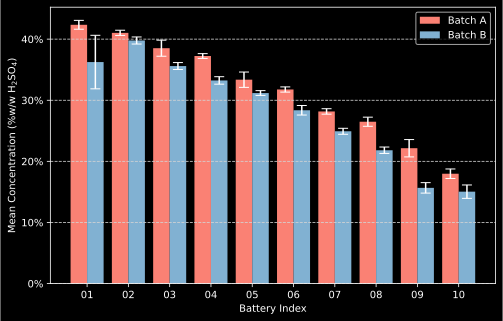

In [46]:
def plotMeanDensityByBatch(
    mean: pd.Series,
    std: pd.Series,
    lightModeOverride: bool = False,
) -> plt.Figure:
    """
    Plot a bar chart of the mean density for each battery, grouped by batch.

    Each index is the battery number 01-10.
    """

    fig, ax = plt.subplots()

    for batch, group in mean.groupby("Batch"):
        ax.bar(
            group["Number"],
            group["Density (wt%)"],
            yerr=std[std["Batch"] == batch]["Density (wt%)"],
            label=f"Batch {batch}",
            capsize=5,
            align="edge",
            width=0.4 * (1 if batch == "B" else -1),
            ecolor=("black" if lightModeOverride or darkdetect.isLight() else "white"),
            color="C03" if batch == "A" else "C04",
        )

    ax.set_xlabel("Battery Index")
    ax.set_ylabel(r"Mean Concentration (%w/w H$_2$SO$_4$)")
    ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    ax.legend()
    ax.grid(
        True,
        linestyle="--",
        color="lightgrey" if not lightModeOverride and darkdetect.isDark() else "grey",
        axis="y",
    )
    # fig.suptitle("Mean Cell Concentration by Battery")

    return fig


plotMeanDensityByBatch(DENSITY_MEAN, DENSITY_STD)

## Tikz Figures

In [47]:
import os
import matplotlib

matplotlib.use("pgf")

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

tikzSaveDir = "../Plots/Latex"
os.makedirs(tikzSaveDir, exist_ok=True)

In [48]:
densityByBatchFig = plotDensityVoltageScatterByBatch(
    DATA,
    lightModeOverride=True,
)
densityByBatchFig.savefig(
    os.path.join(tikzSaveDir, "densityByBatch.pgf"),
    bbox_inches="tight",
)

In [49]:
densityBarFigure = plotMeanDensityByBatch(
    DENSITY_MEAN,
    DENSITY_STD,
    lightModeOverride=True,
)
densityBarFigure.savefig(
    os.path.join(tikzSaveDir, "densityBar.pgf"),
    bbox_inches="tight",
)